## 📚 Prerequisites

Before executing this notebook, make sure you have properly set up your Azure Services, created your Conda environment, and configured your environment variables as per the instructions provided in the [README.md](README.md) file.


## Understanding Quantitative Measures of Relevance

In order to evaluate the effectiveness of our search system, we use several metrics that measure the relevance of the results it returns. These metrics help us understand how well our system is performing and guide us in tuning it for better performance.

+ **NDCG@10**: Normalized Discounted Cumulative Gain at 10 (NDCG@10) is a metric that assesses the effectiveness of a retrieval system at finding and correctly ordering the top 10 documents. The score ranges from 0 to 100, with higher scores indicating that the system's ordered list of documents closely matches the ideal order. This metric is widely used because it balances the need for precision (returning relevant results) with the need for proper sequencing (ordering the results correctly).

- **NDCG@3**: NDCG@3 is similar to NDCG@10, but it focuses on the top 3 documents. This metric is particularly relevant in contexts where it's crucial to have the highest accuracy in the topmost results, such as in generative AI applications. NDCG@3 measures the system's ability to identify and correctly rank the three most relevant documents.

+ **Recall@50**: Recall@50 measures the proportion of high-quality documents identified within the top 50 results. It's calculated by counting the number of documents rated as high quality by a scoring prompt and dividing this by the total number of known good documents for a given query. This metric is useful for assessing the system's ability to retrieve a broad set of relevant documents from a large pool.

To automate the evaluation process, we use supervised tuning techniques. These techniques involve training a model on a labeled dataset, where the labels indicate the relevance of the documents to the queries. The model learns to predict the relevance of a document to a query, and we can then use these predictions to calculate the metrics above. This allows us to measure the relevance of our queries in an automated and scalable way.

## Dataset Creation

To assess the qualitative performance of our search store in alignment with the BEIR framework, we follow a three-step process to generate our evaluation dataset:

1. **Corpus Creation:**
   We begin by extracting document chunks from our Azure Search index. These chunks are consolidated into a corpus file (`corpus.jsonl`), ensuring that the foundational set of documents is standardized and comprehensive for subsequent evaluation.

2. **Query Generation:**
   Next, we utilize GPT-4o to generate a diverse set of queries based on five carefully selected diagnosis and medication scenarios from our medical index. This targeted approach ensures that the queries are medically relevant and reflective of real-world clinical information needs. The generated queries are stored in `queries.jsonl`.

3. **Relevance Judgments:**
   Finally, we employ an LLM-as-a-judge to evaluate the relevance of the documents with respect to each query. This evaluation produces relevance judgments that are saved in `qrel.jsonl`. These qrels form the basis for computing our performance metrics, including NDCG@10, NDCG@3, and Recall@50.

You can use the below cells to generate your own dataset, please uncomment the code and run it. The dataset will be saved in the `evals/benchmark/medindexer` directory, where our existing datasets have been curated.


In [4]:
from opentelemetry.propagate import extract

from src.pipeline.promptEngineering.prompt_manager import PromptManager
from src.aoai.aoai_helper import AzureOpenAIManager
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from dotenv import load_dotenv
import nest_asyncio
import asyncio
import json
import os
from tqdm import tqdm
import math
import json
import os
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.models import (
    VectorizableTextQuery,
    QueryType,
    QueryCaptionType,
    QueryAnswerType,
)
import json
from beir.retrieval.evaluation import EvaluateRetrieval
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

load_dotenv()

# Setup configuration variables for Azure and MedImageInsight
search_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT")
search_admin_key = os.getenv("AZURE_AI_SEARCH_ADMIN_KEY")
search_index_name = os.getenv("AZURE_IMAGES_SEARCH_INDEX_NAME", "ai-policies-index")
root = os.path.dirname(os.getcwd())
aoai_client = AzureOpenAIManager()
prompt_manager = PromptManager()

Templates found: ['evaluator_system_prompt.jinja', 'evaluator_user_prompt.jinja', 'formulator_system_prompt.jinja', 'formulator_user_prompt.jinja', 'ner_clinician_system.jinja', 'ner_clinician_user.jinja', 'ner_patient_system.jinja', 'ner_patient_user.jinja', 'ner_physician_system.jinja', 'ner_physician_user.jinja', 'ner_system_prompt.jinja', 'ner_user_prompt.jinja', 'prior_auth_o1_user_prompt.jinja', 'prior_auth_o1_user_prompt_b.jinja', 'prior_auth_system_prompt.jinja', 'prior_auth_user_prompt.jinja', 'query_classificator_system_prompt.jinja', 'query_classificator_user_prompt.jinja', 'query_expansion_system_prompt.jinja', 'query_expansion_user_prompt.jinja', 'query_generation_eval_system_prompt.jinja', 'query_generation_eval_user_prompt.jinja', 'query_relevance_eval_system_prompt.jinja', 'query_relevance_eval_user_prompt.jinja', 'query_relevance_eval_user_prompt_bkp.jinja', 'summarize_policy_system.jinja', 'summarize_policy_user.jinja']


In [5]:
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=search_index_name,
    credential=AzureKeyCredential(search_admin_key)
)

results = search_client.search("*", include_total_count=True)
dataset_dir = "evals/benchmark/medindexer"

# # Uncomment lines below to run the saving.
# with open(os.path.join(root, dataset_dir, "corpus.jsonl"), "w") as f:
#     for i, result in enumerate(results, start=1):
#         # Remove keys starting with "@search"
#         filtered_result = {k: v for k, v in result.items() if not k.startswith("@search")}
#         filtered_result["id"] = f"d{i}"
#         json_line = json.dumps(filtered_result, separators=(',', ':'), sort_keys=True)
#         f.write(json_line + "\n")
# 
# print("Corpus saved to corpus.jsonl")

queries.jsonl:

In [15]:
run_queries = False
use_cases = [
    {
        "diagnosis": "Inflammatory Bowel Disease (Crohn’s)",
        "medication": "Adalimumab",
        "title" : "001.pdf"
    },
    {
        "diagnosis": "Lennox-Gastaut Syndrome",
        "medication": "Epidiolex",
        "title" : "002.pdf"
    },
    {
        "diagnosis": "Lymphoblastic Leukemia (B-ALL), Philadelphia chromosome-negative",
        "medication": "Blinatumomab",
        "title" : "003.pdf"
    },
    {
        "diagnosis": "Severe Atopic Dermatitis",
        "medication": "Dupilumab",
        "title" : "004.pdf"
    },
    {
        "diagnosis": "High-grade Osteosarcoma",
        "medication": "Everolimus",
        "title" : "005.pdf"
    }
]

nest_asyncio.apply()

queries_flattened = []
if run_queries:
    for use_case in use_cases:
        diagnosis = use_case["diagnosis"]
        medication = use_case["medication"]
        title = use_case["title"]
        
        user_query_generation_prompt = prompt_manager.create_prompt_query_generation_eval_user(
            diagnosis=diagnosis,
            medication=medication
        )
        system_query_generation_prompt = prompt_manager.create_prompt_query_generation_eval_system()
        query_response = await aoai_client.generate_chat_response(
            query=user_query_generation_prompt,
            system_message_content=system_query_generation_prompt,
            image_paths=[],  # No images are needed for this prompt.
            stream=False,
            response_format="text",  # Requesting plain text (markdown formatted) output.
        )
        queries = json.loads(query_response['response'])['queries']
    
        # Merge the original use case fields with the generated query
        for query in queries:
            query_object = {
                "diagnosis": diagnosis,
                "medication": medication,
                "title" : title,
                "query": query
            }
            queries_flattened.append(query_object)

# # Save the queries to a minified JSONL file (one JSON object per line)
# with open(os.path.join(root, dataset_dir, "queries.jsonl"), "w") as f:
#     for i, query in enumerate(queries_flattened, start=1):
#         query["id"] = f"q{i}"
#         json_line = json.dumps(query, separators=(',', ':'))
#         f.write(json_line + "\n")
# 
# print("queries.jsonl file has been generated.")

In [16]:
with open(os.path.join(root, dataset_dir, "corpus.jsonl"), "r") as f:
    corpus_data = [
        {k: d[k] for k in ("chunk", "id", "title", "chunk_id") if k in d}
        for d in (json.loads(line) for line in f if line.strip())
    ]

with open(os.path.join(root, dataset_dir, "queries.jsonl"), "r") as f:
    queries_data = [json.loads(line) for line in f if line.strip()]
    
response_format = {
    "type": "json_schema",
    "json_schema": {
        "name": "relevance_scoring_response",
        "schema": {
            "type": "object",
            "properties": {
                "results": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "query": {"type": "string"},
                            "document": {"type": "string"},
                            "relevant": {
                                "type": "integer",
                                "enum": [0, 1],
                                "description": "Binary indicator for relevance"
                            },
                            "relevant_score": {
                                "type": "integer",
                                "description": "Score from 1 (least relevant) to 5 (most relevant)"
                            },
                            "thought_chain": {
                                "type": "string",
                                "description": "Reasoning behind the evaluation"
                            },
                            "explanation": {
                                "type": "string",
                                "description": "User-facing explanation"
                            }
                        },
                        "required": [
                            "query", "document", "relevant",
                            "relevant_score", "thought_chain", "explanation"
                        ],
                        "additionalProperties": False  # ✅ required in strict mode
                    }
                }
            },
            "required": ["results"],
            "additionalProperties": False  # ✅ required in strict mode
        },
        "strict": True
    }
}


In [17]:
block_size = 3
run_relevance = True
semaphore = asyncio.Semaphore(10)  # Increase based on your quota TPM/RPM

async def process_block(query_obj, corpus_block):
    async with semaphore:
        query_id = query_obj["id"]
        query_text = query_obj["query"]
        title = query_obj.get("title", "")
        corpus_str = json.dumps(corpus_block, indent=2)
        
        user_prompt = prompt_manager.create_prompt_query_relevance_eval_user(
            corpus=corpus_str,
            query_id=query_id,
            query=query_text,
            title=title,
        )
        system_prompt = prompt_manager.create_prompt_query_relevance_eval_system()
        
        response = await aoai_client.generate_chat_response(
            query=user_prompt,
            system_message_content=system_prompt,
            image_paths=[],  # No images are needed for this prompt.
            stream=False,
            response_format=response_format,
            max_tokens=2000,
        )

        parsed_response = json.loads(response["response"])
        return parsed_response

async def process_queries(queries_data, corpus_data):
    overall_progress = tqdm(total=len(queries_data), desc="Processing Queries")
    qrels_flattened = []
    
    # Process each query individually to allow a nested progress bar per query.
    for query_obj in queries_data:
        num_blocks = math.ceil(len(corpus_data) / block_size)
        block_progress = tqdm(total=num_blocks, desc=f"Query {query_obj['id']} Blocks", leave=False)
        query_qrels = []
        
        # Create tasks for each block for this query.
        tasks = [
            asyncio.create_task(process_block(query_obj, corpus_data[i:i + block_size]))
            for i in range(0, len(corpus_data), block_size)
        ]
        
        # Process the tasks as they complete.
        for future in asyncio.as_completed(tasks):
            parsed_response = await future
            query_qrels.extend(parsed_response["results"])
            block_progress.update(1)
        block_progress.close()
        
        overall_progress.update(1)
        qrels_flattened.extend(query_qrels)
    overall_progress.close()
    
    return qrels_flattened

# Only execute the processing if run_relevance is True
if run_relevance:
    qrels_flattened = await process_queries(queries_data, corpus_data)
    
    # Write the combined results to the qrels.jsonl file.
    with open(os.path.join(root, dataset_dir, "qrels.jsonl"), "w") as f:
        for qrel in qrels_flattened:
            json_line = json.dumps(qrel, separators=(',', ':'), sort_keys=True)
            f.write(json_line + "\n")
    
    print("qrels.jsonl file has been generated.")

Query q3 Blocks:   0%|          | 0/9 [00:00<?, ?it/s]2025-04-01 22:17:08,806 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:17:08 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:17:08,806 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:17:08 (aoai_helper.py:generate_chat_response:440)
2025-04-01 22:17:30,144 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:17:30 (Duration: 21.34 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:17:30,146 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:17:30 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:17:30,146 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:17:30 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q3","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d1 discusses various conditions like Behcet\'s Disease, Pyoderma Gangrenosum, and Sarcoidosis related to the use of Adalimumab, but it does not mention inflammatory bowel disease or prior authorization requirements specific to it.","explanation":"The document discusses other conditions but not inflammatory bowel disease or prior authorization requirements related to it, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query focuses on prior authorization requirements for Adalimumab in the context of inflammatory bowel disease. Document d2 lists various Adalimumab products and mentions coverage policies related to FDA-approv

2025-04-01 22:17:39,541 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:17:39 (Duration: 9.39 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:17:39,544 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:17:39 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:17:39,545 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:17:39 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q3","document":"d7","relevant":1,"relevant_score":3,"thought_chain":"Let\'s think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d7 discusses prior authorization policies for Adalimumab products and mentions ulcerative colitis, which is a type of inflammatory bowel disease. However, it doesn\'t fully detail the prior authorization requirements for all types of inflammatory bowel disease.","explanation":"The document addresses ulcerative colitis, a form of inflammatory bowel disease, but lacks comprehensive details on prior authorization requirements for the broader category. Score: 3 (Incomplete Response)."},{"query":"q3","document":"d8","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is about prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d8 focuses on spondyloarthritis and arthritis associated with

2025-04-01 22:17:45,987 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:17:45 (Duration: 6.44 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:17:45,991 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:17:45 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:17:45,992 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:17:45 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q3","document":"d15","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d15 discusses conditions like Hidradenitis Suppurativa and Plaque Psoriasis, but it does not mention inflammatory bowel disease or give relevant prior authorization details for it.","explanation":"The document does not address inflammatory bowel disease or its prior authorization requirements, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d16","relevant":1,"relevant_score":4,"thought_chain":"Let\'s think step by step: The query is seeking prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d16 specifically addresses ulcerative colitis, a type of inflammatory bowel disease, and provides detailed authorization criteria, which is directly relevant to the query.","explan

2025-04-01 22:17:54,301 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:17:54 (Duration: 8.31 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:17:54,304 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:17:54 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:17:54,305 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:17:54 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q3","document":"d18","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d18 mentions various guidelines, including those for Crohn\'s Disease, but does not provide specific prior authorization criteria for Adalimumab in inflammatory bowel disease.","explanation":"The document mentions Crohn\'s Disease but lacks specific prior authorization details, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is focused on prior authorization for Adalimumab in inflammatory bowel disease. Document d21 discusses general coverage policies and the role of medical directors in coverage decisions but does not mention inflammatory bowel disease or specific prior authorization criteria for Adalimumab.","exp

2025-04-01 22:18:03,291 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:18:03 (Duration: 8.99 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:18:03,294 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:18:03 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:18:03,295 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:18:03 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q3","document":"d23","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query requests prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d23 discusses conditions like Plaque Psoriasis, but there is no mention of inflammatory bowel disease or related prior authorization criteria.","explanation":"The document does not address inflammatory bowel disease or its prior authorization requirements, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d24","relevant":1,"relevant_score":4,"thought_chain":"Let\'s think step by step: The query seeks prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d24 mentions objective measures for assessing clinical response to Adalimumab and includes consultation with a gastroenterologist. This is relevant to inflammatory bowel disease treatment protocols.","explanation":"The docu

2025-04-01 22:18:14,688 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:18:14 (Duration: 11.39 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:18:14,689 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:18:14 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:18:14,689 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:18:14 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q3","document":"d31","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d31 lists various Adalimumab products and discusses general policy instructions, but does not specifically address inflammatory bowel disease or provide relevant prior authorization criteria.","explanation":"The document focuses on general policy instructions and does not address inflammatory bowel disease, making it irrelevant. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d32","relevant":1,"relevant_score":4,"thought_chain":"Let\'s think step by step: The query is about prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d32 provides specific criteria for approval of Adalimumab, including after ileocolonic resection for Crohn\'s disease, a type of inflammatory bowel disease, making it relevant to th

2025-04-01 22:18:25,605 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:18:25 (Duration: 10.92 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:18:25,609 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:18:25 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:18:25,610 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:18:25 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q3","document":"d34","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d34 mentions ophthalmic conditions and does not address inflammatory bowel disease or prior authorization requirements related to it.","explanation":"The document is off-topic and unrelated to inflammatory bowel disease. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d39","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is focused on prior authorization for Adalimumab in inflammatory bowel disease. Document d39 lists various biologic treatments for different conditions, including inflammatory bowel disease, but does not provide specific prior authorization criteria for Adalimumab.","explanation":"The document lists biologics but lacks specific prior authorization details for Adalimumab in inflammatory

2025-04-01 22:18:34,010 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:18:34 (Duration: 8.40 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:18:34,014 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:18:34 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:18:34,015 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:18:34 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q3","document":"d41","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d41 discusses general authorization criteria but does not mention inflammatory bowel disease or specific criteria related to it.","explanation":"The document does not address inflammatory bowel disease, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d44","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is focused on prior authorization for Adalimumab in inflammatory bowel disease. Document d44 discusses authorization criteria for conditions like Psoriatic Arthritis and does not mention inflammatory bowel disease.","explanation":"The document does not address inflammatory bowel disease or relevant authorization criteria for it. Score: 1 (Irrelevant Response)."},{"quer

2025-04-01 22:18:53,438 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:18:53 (Duration: 19.42 seconds) (aoai_helper.py:generate_chat_response:494)

Processing Queries:  50%|█████     | 1/2 [01:44<01:44, 104.68s/it]

{'response': '{"results":[{"query":"q3","document":"d48","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for prior authorization requirements for Adalimumab in inflammatory bowel disease. Document d48 discusses general changes to criteria for various conditions but does not mention inflammatory bowel disease specifically.","explanation":"The document does not address inflammatory bowel disease, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q3","document":"d50","relevant":1,"relevant_score":3,"thought_chain":"Let\'s think step by step: The query is focused on prior authorization for Adalimumab in inflammatory bowel disease. Document d50 provides an overview of Adalimumab uses, including Crohn\'s disease and ulcerative colitis, which are types of inflammatory bowel disease, but does not detail the specific prior authorization requirements.","explanation":"The document mentions uses for Crohn\'s disease and ulcera


Query q7 Blocks:   0%|          | 0/9 [00:00<?, ?it/s]2025-04-01 22:18:53,453 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:18:53 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:18:53,454 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:18:53 (aoai_helper.py:generate_chat_response:440)
2025-04-01 22:19:05,094 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:19:05 (Duration: 11.64 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:19:05,096 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:19:05 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:19:05,097 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:19:05 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q7","document":"d1","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is about Crohn\'s Adalimumab medication authorization guidelines. Document d1 discusses other conditions like Behcet\'s Disease and Sarcoidosis but does not mention Crohn\'s disease or provide relevant authorization guidelines.","explanation":"The document does not address Crohn\'s disease authorization guidelines, making it irrelevant. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d2","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for Crohn\'s Adalimumab medication authorization guidelines. Document d2 lists various Adalimumab products and general policy criteria but does not specify Crohn\'s disease or its authorization guidelines.","explanation":"The document does not provide specific information on Crohn\'s disease authorization. Score: 1 (Irrelevant Response)."},{"query":"q7","documen

2025-04-01 22:19:31,216 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:19:31 (Duration: 26.12 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:19:31,221 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:19:31 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:19:31,222 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:19:31 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q7","document":"d7","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query seeks Crohn\'s Adalimumab medication authorization guidelines. Document d7 discusses ulcerative colitis and pouchitis, not Crohn\'s disease. Therefore, it doesn\'t provide the needed authorization guidelines for Crohn\'s disease.","explanation":"The document is focused on ulcerative colitis and doesn\'t mention Crohn\'s disease, making it irrelevant. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d8","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is about Crohn\'s Adalimumab medication authorization guidelines. Document d8 discusses spondyloarthritis and arthritis associated with inflammatory bowel disease but doesn\'t provide specific authorization guidelines for Crohn\'s disease.","explanation":"The document does not address Crohn\'s disease authorization guidelines. Score: 1 (Irrelevant Respo

2025-04-01 22:19:52,745 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:19:52 (Duration: 21.52 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:19:52,747 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:19:52 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:19:52,747 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:19:52 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q7","document":"d15","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is about Crohn\'s Adalimumab medication authorization guidelines. Document d15 discusses authorization criteria for conditions like Hidradenitis Suppurativa and Plaque Psoriasis but does not mention Crohn\'s disease.","explanation":"The document does not address Crohn\'s disease, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d16","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query requests Crohn\'s Adalimumab medication authorization guidelines. Document d16 focuses on rheumatoid arthritis and ulcerative colitis, without mentioning Crohn\'s disease or its authorization guidelines.","explanation":"The document does not mention Crohn\'s disease, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d17","relevant":0,"relevant

2025-04-01 22:20:04,097 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:20:04 (Duration: 11.35 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:20:04,100 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:20:04 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:20:04,100 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:20:04 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q7","document":"d18","relevant":1,"relevant_score":3,"thought_chain":"Let\'s think step by step: The query asks for Crohn\'s Adalimumab medication authorization guidelines. Document d18 references a guideline for Crohn\'s Disease management, which is relevant, but it doesn\'t provide detailed authorization criteria for Adalimumab.","explanation":"The document mentions guidelines for Crohn\'s Disease but lacks specific authorization details for Adalimumab. Score: 3 (Incomplete Response)."},{"query":"q7","document":"d21","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is focused on Crohn\'s Adalimumab medication authorization guidelines. Document d21 discusses coverage policies for health benefit plans without specific reference to Crohn\'s Disease or Adalimumab authorization guidelines.","explanation":"The document does not address Crohn\'s Disease or Adalimumab authorization. Score: 1 (Irrelevant Response)."},{"q

2025-04-01 22:20:29,247 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:20:29 (Duration: 25.15 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:20:29,252 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:20:29 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:20:29,253 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:20:29 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q7","document":"d23","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for Crohn\'s Adalimumab medication authorization guidelines. Document d23 discusses Plaque Psoriasis authorization criteria and does not mention Crohn\'s disease.","explanation":"Document d23 is irrelevant as it does not address Crohn\'s disease authorization guidelines. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d24","relevant":1,"relevant_score":3,"thought_chain":"Let\'s think step by step: The query is focused on Crohn\'s Adalimumab medication authorization guidelines. Document d24 includes criteria involving a gastroenterologist and mentions fecal markers, which could relate to Crohn\'s disease, but lacks specific guidelines.","explanation":"The document vaguely relates to Crohn\'s disease but lacks specific guidelines, making it incomplete. Score: 3 (Incomplete Response)."},{"query":"q7","document":"d25","relevant":1,"

2025-04-01 22:20:55,142 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:20:55 (Duration: 25.89 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:20:55,149 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:20:55 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:20:55,150 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:20:55 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q7","document":"d31","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for Crohn\'s Adalimumab medication authorization guidelines. Document d31 discusses general coverage policies for various Adalimumab products but does not mention Crohn\'s disease or specific authorization guidelines.","explanation":"The document does not address Crohn\'s disease authorization guidelines, making it irrelevant. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d32","relevant":1,"relevant_score":3,"thought_chain":"Let\'s think step by step: The query seeks Crohn\'s Adalimumab medication authorization guidelines. Document d32 mentions the use of Adalimumab for Crohn\'s disease post-ileocolonic resection, which is relevant, but lacks comprehensive authorization guidelines.","explanation":"The document references Crohn\'s disease treatment but lacks detailed authorization guidelines. Score: 3 (Incomplete Response)."},{

2025-04-01 22:21:41,408 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:21:41 (Duration: 46.26 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:21:41,413 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:21:41 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:21:41,414 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:21:41 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q7","document":"d34","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for Crohn\'s Adalimumab medication authorization guidelines. Document d34 discusses general approval criteria for conditions requiring ophthalmology consultation, which does not relate to Crohn\'s disease or its medication authorization.","explanation":"The document is irrelevant to Crohn\'s disease authorization guidelines. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d39","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query seeks Crohn\'s Adalimumab medication authorization guidelines. Document d39 lists various biologic products and their indications but does not specify authorization guidelines for Crohn\'s disease.","explanation":"The document does not address Crohn\'s disease authorization guidelines, making it irrelevant. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d40",

2025-04-01 22:22:15,603 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:22:15 (Duration: 34.19 seconds) (aoai_helper.py:generate_chat_response:494)
2025-04-01 22:22:15,608 - micro - MainProcess - INFO     Function generate_chat_response started at 2025-04-01 22:22:15 (aoai_helper.py:generate_chat_response:383)
2025-04-01 22:22:15,611 - micro - MainProcess - INFO     Sending request to Azure OpenAI at 2025-04-01 22:22:15 (aoai_helper.py:generate_chat_response:440)


{'response': '{"results":[{"query":"q7","document":"d41","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query is about Crohn\'s Adalimumab medication authorization guidelines. Document d41 discusses general criteria for various conditions but does not mention Crohn\'s disease or specific authorization guidelines for it.","explanation":"The document does not address Crohn\'s disease authorization guidelines, making it irrelevant. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d44","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query seeks Crohn\'s Adalimumab medication authorization guidelines. Document d44 covers criteria related to Psoriatic Arthritis and does not mention Crohn\'s disease or specific authorization guidelines.","explanation":"The document does not mention Crohn\'s disease, making it irrelevant to the query. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d45","relevant":0,"releva

2025-04-01 22:22:31,493 - micro - MainProcess - INFO     Function generate_chat_response finished at 2025-04-01 22:22:31 (Duration: 15.88 seconds) (aoai_helper.py:generate_chat_response:494)

Processing Queries: 100%|██████████| 2/2 [05:22<00:00, 161.37s/it]

{'response': '{"results":[{"query":"q7","document":"d48","relevant":0,"relevant_score":1,"thought_chain":"Let\'s think step by step: The query asks for Crohn\'s Adalimumab medication authorization guidelines. Document d48 discusses revisions to authorization criteria for various conditions but does not mention Crohn\'s disease.","explanation":"The document does not address Crohn\'s disease authorization guidelines, making it irrelevant. Score: 1 (Irrelevant Response)."},{"query":"q7","document":"d50","relevant":1,"relevant_score":3,"thought_chain":"Let\'s think step by step: The query seeks Crohn\'s Adalimumab medication authorization guidelines. Document d50 mentions Crohn\'s disease and general guidelines for TNFi use in its treatment, but lacks specific authorization details.","explanation":"The document relates to Crohn\'s disease treatment but lacks detailed authorization criteria. Score: 3 (Incomplete Response)."},{"query":"q7","document":"d51","relevant":1,"relevant_score":4,"th

build rankings

In [22]:
with open(os.path.join(root, dataset_dir, "qrels.jsonl"), "r") as f:
    qrels_data = [json.loads(line) for line in f if line.strip()]

def extract_chunk_id(full_chunk_id):
    # Split on the FIRST underscore only
    parts = full_chunk_id.split("_", 1)
    return parts[1]

def get_doc_id(chunk_id, corpus_data):
    """
    Return a list of (id, chunk) tuples where 'query_text' is found in the chunk string.
    """
    return [x['id'] for x in corpus_data if extract_chunk_id(x["chunk_id"]) == extract_chunk_id(chunk_id)][0]

def run_search(query_text, mode, top_n=50):
    """
    Run a search for the given query text and mode.

    Possible modes:
      - "hybrid_reranker"
      - "semantic_search"
      - "keyword_search"
      - "hybrid_semantic_reranker"

    Returns a dictionary mapping document IDs to the chosen score field.
    """
    vector_query = VectorizableTextQuery(
        text=query_text,
        fields="vector",
        k_nearest_neighbors=5,
        weight=0.5               
    )
    if mode == "keyword":
        # Basic keyword (lexical) search
        results = search_client.search(
            search_text=query_text,
            top=top_n,
            query_type=QueryType.FULL,
        )
        sort_field = "@search.score"
    elif mode == "hybrid-semantic":
        results = search_client.search(
            search_text=query_text,
            vector_queries=[vector_query],
            query_type=QueryType.SEMANTIC,
            semantic_configuration_name="my-semantic-config",
            query_caption=QueryCaptionType.EXTRACTIVE,
            query_answer=QueryAnswerType.EXTRACTIVE,
            top=top_n,
        )
        sort_field = "@search.reranker_score"
    elif mode == "hybrid":
        results = search_client.search(
            search_text=query_text,
            vector_queries=[vector_query],
            query_type=QueryType.FULL,
            top=top_n,
        )
        sort_field = "@search.score"
    elif mode == "vector":
        results = search_client.search(
            search_text=None,
            vector_queries=[vector_query],
            query_type=QueryType.FULL,
            top=top_n,
        )
        sort_field = "@search.score"
    else:
        raise ValueError("Invalid search mode provided.")

    # Convert results to a ranking dict: {document_id: sort_field_value}
    ranking = {}
    for result in results:
        try:
            doc_id = get_doc_id(result["chunk_id"], corpus_data)
            score_val = getattr(result, sort_field, None)
            if score_val is None:
                score_val = result[sort_field] if sort_field in result else None
            ranking[doc_id] = score_val
        except IndexError:
            print(f"Error: Could not find document ID for chunk ID: %s and title: %s" % (result["chunk_id"], result["title"]))
            continue

    return ranking

# Define output file paths.
output_keyword = os.path.join(root, dataset_dir, "rankings-keyword.jsonl")
output_vector = os.path.join(root, dataset_dir, "rankings-vector.jsonl")
output_hybrid = os.path.join(root, dataset_dir, "rankings-hybrid.jsonl")
output_hybrid_semantic = os.path.join(root, dataset_dir, "rankings-hybrid-semantic.jsonl")

# Open all three output files at once.
with open(output_hybrid, "w", encoding="utf-8") as fout_hybrid, \
     open(output_hybrid_semantic, "w", encoding="utf-8") as fout_hybrid_semantic, \
     open(output_keyword, "w", encoding="utf-8") as fout_keyword, \
     open(output_vector, "w", encoding="utf-8") as fout_vector:
    
    # Process each query once.
    for query in queries_data:
        query_id = query["id"]
        query_text = query["query"]

        # Run searches for each mode.
        ranking_hybrid = run_search(query_text, mode="hybrid")
        ranking_semantic = run_search(query_text, mode="hybrid-semantic")
        ranking_keyword = run_search(query_text, mode="keyword")
        ranking_vector = run_search(query_text, mode="vector")
        
        # Write the hybrid and semantic results as JSON lines.
        fout_hybrid.write(json.dumps({"query": query_id, "ranking": ranking_hybrid}) + "\n")
        fout_hybrid_semantic.write(json.dumps({"query": query_id, "ranking": ranking_semantic}) + "\n")
        fout_keyword.write(json.dumps({"query": query_id, "ranking": ranking_keyword}) + "\n")
        fout_vector.write(json.dumps({"query": query_id, "ranking": ranking_vector}) + "\n")
        
        print(f"Processed query {query_id}")

Error: Could not find document ID for chunk ID: 4fa106cdfad7_aHR0cHM6Ly9zdG9yYWdlYXV0b2F1dGhydHpud3BxLmJsb2IuY29yZS53aW5kb3dzLm5ldC9wcmUtYXV0aC1wb2xpY2llcy9wb2xpY2llc19vY3IvMDAxLnBkZg2_normalized_images_5_pages_1 and title: 001.pdf
Error: Could not find document ID for chunk ID: 4fa106cdfad7_aHR0cHM6Ly9zdG9yYWdlYXV0b2F1dGhydHpud3BxLmJsb2IuY29yZS53aW5kb3dzLm5ldC9wcmUtYXV0aC1wb2xpY2llcy9wb2xpY2llc19vY3IvMDAxLnBkZg2_normalized_images_2_pages_1 and title: 001.pdf
Error: Could not find document ID for chunk ID: 4fa106cdfad7_aHR0cHM6Ly9zdG9yYWdlYXV0b2F1dGhydHpud3BxLmJsb2IuY29yZS53aW5kb3dzLm5ldC9wcmUtYXV0aC1wb2xpY2llcy9wb2xpY2llc19vY3IvMDAxLnBkZg2_normalized_images_11_pages_0 and title: 001.pdf
Error: Could not find document ID for chunk ID: 4fa106cdfad7_aHR0cHM6Ly9zdG9yYWdlYXV0b2F1dGhydHpud3BxLmJsb2IuY29yZS53aW5kb3dzLm5ldC9wcmUtYXV0aC1wb2xpY2llcy9wb2xpY2llc19vY3IvMDAxLnBkZg2_normalized_images_17_pages_0 and title: 001.pdf
Error: Could not find document ID for chunk ID: 4fa106cdfad7_aHR0cHM6L

Evaluation Metrics:
           BEIR-Keyword  BEIR-Vector  BEIR-Hybrid (Keyword + Vector)  \
NDCG@3          0.61732      0.76536                         0.85196   
NDCG@10         0.54896      0.50234                         0.67237   
Recall@10       0.54861      0.41667                         0.60417   

           BEIR-Hybrid + Semantic  
NDCG@3                    0.50000  
NDCG@10                   0.50858  
Recall@10                 0.53472  


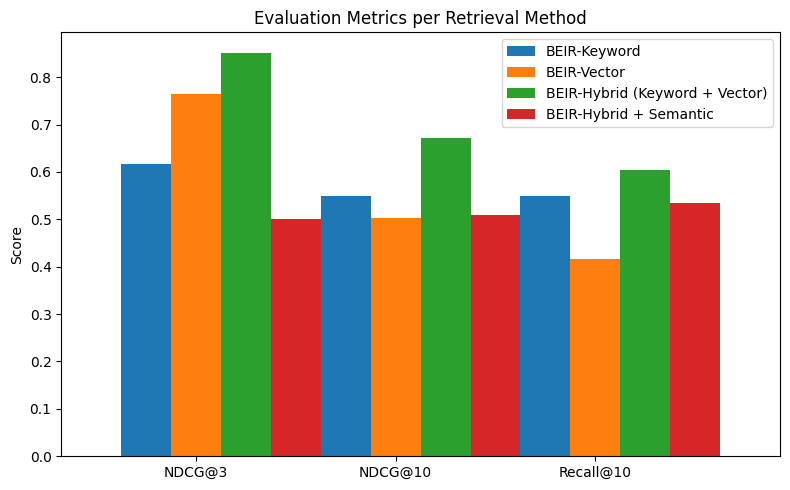

In [23]:
def load_run_dict(run_file):
    with open(os.path.join(root, dataset_dir, run_file), "r", encoding="utf-8") as f:
        run_data = [json.loads(line) for line in f if line.strip()]
    return {entry["query"]: entry["ranking"] for entry in run_data}

# Load qrels data (list of dictionaries) and convert to nested dict format.
qrels_dict = {q: {entry["document"]: int(entry["relevant"])
                  for entry in qrels_data if entry["query"] == q}
              for q in {entry["query"] for entry in qrels_data}}

# Define ranking files for the three retrieval methods.
ranking_files = {
    "BEIR-Keyword": "rankings-keyword.jsonl",
    "BEIR-Vector": "rankings-vector.jsonl",
    "BEIR-Hybrid (Keyword + Vector)": "rankings-hybrid.jsonl",
    "BEIR-Hybrid + Semantic": "rankings-hybrid-semantic.jsonl",
}

# Initialize a dictionary to store metrics for each retrieval method.
metrics_results = {}

# Create the BEIR evaluator.
evaluator = EvaluateRetrieval()

# For each ranking file, load the run, evaluate, and store the desired metrics.
for method_name, run_file in ranking_files.items():
    run_dict = load_run_dict(run_file)
    results = evaluator.evaluate(qrels_dict, run_dict, k_values=[3, 10])
    metrics_results[method_name] = {
        "NDCG@3": results[0]["NDCG@3"],
        "NDCG@10": results[0]["NDCG@10"],
        "Recall@10": results[2]["Recall@10"]
    }

# Create a DataFrame from the metrics results.
df = pd.DataFrame(metrics_results, index=["NDCG@3", "NDCG@10", "Recall@10"])
print("Evaluation Metrics:")
print(df)

# Plot the results as a grouped bar chart.
metrics = df.index.tolist()          # Metrics on x-axis.
methods = df.columns.tolist()        # Retrieval methods.
x = np.arange(len(metrics))          # Label positions.
width = 0.25                         # Bar width

fig, ax = plt.subplots(figsize=(8, 5))
for idx, method in enumerate(methods):
    ax.bar(x + idx * width, df[method], width, label=method)

# Customize plot appearance.
ax.set_ylabel('Score')
ax.set_title('Evaluation Metrics per Retrieval Method')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
ax.margins(x=0.1)  # Adjust the fraction as needed

plt.tight_layout()
plt.show()